## Step 1 - Import and init

You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL :
- 0 = all messages are logged (default)
- 1 = INFO messages are not printed.
- 2 = INFO and WARNING messages are not printed.
- 3 = INFO , WARNING and ERROR messages are not printed.

In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.display import display

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

# sys.path.append('..')
# import fidle.pwk as pwk

import data_io
from classes.block import Block
from classes.triplet import Triplet
from classes.shot import Shot
from classes.ccd import CCD

# datasets_dir = pwk.init('BHPD1')

Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [2]:
fit_verbosity = 1

## Step 2 - Retrieve data

In [3]:
data_io.loadAll()
data = data_io.get_ai_ready(subsets_per_block=100)

Loading 2013AE.yml
Loading 2013AO.yml
Loading 2013BL.yml
Loading 2015AM.yml
Loading 2015AP.yml
Loading 2015BS.yml
Loading 2015BT.yml
Loading 2015BD.yml
Loading 2014BH.yml
Loading 2015BC.yml
2015BD


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 70% of the data for training and 30% for validation.  
The dataset is **shuffled** and shared between **learning** and **testing**.  
x will be input data and y the expected output

In [4]:
# ---- Shuffle and Split => train, test
#

train_prop = 0.7

train_sets = int(len(data)*train_prop)

index = np.zeros(len(data),dtype=bool)
# index[:train_sets] = True
while sum(index) < train_sets:
    index[np.random.randint(0,len(data))] = True

data_train = data[index]
data_test  = data[~index]

# ---- Split => x,y (medv is price)
#
x_train = data_train[:,:-4]
y_train = data_train[:,-4:]
x_test  = data_test[:,:-4]
y_test  = data_test[:,-4:]

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (900, 13828)
x_train :  (630, 13824) y_train :  (630, 4)
x_test  :  (270, 13824) y_test  :  (270, 4)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
# display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

# display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
# display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(4, name='Output'))
  
  model.compile(optimizer = 'adam',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (len(x_train[0]),) )

model.summary()

# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 32)                442400    
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 4)                 132       
                                                                 
Total params: 446,724
Trainable params: 446,724
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Train it

In [8]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 60,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test))

Epoch 1/60
63/63 [==============================] - 1s 6ms/step - loss: 20.0530 - mae: 2.5279 - mse: 20.0530 - val_loss: 2.0422 - val_mae: 0.9875 - val_mse: 2.0422
Epoch 2/60
63/63 [==============================] - 0s 4ms/step - loss: 1.4597 - mae: 0.7959 - mse: 1.4597 - val_loss: 1.5527 - val_mae: 0.7172 - val_mse: 1.5527
Epoch 3/60
63/63 [==============================] - 0s 4ms/step - loss: 1.2212 - mae: 0.6791 - mse: 1.2212 - val_loss: 1.3779 - val_mae: 0.7230 - val_mse: 1.3779
Epoch 4/60
63/63 [==============================] - 0s 4ms/step - loss: 1.0811 - mae: 0.5882 - mse: 1.0811 - val_loss: 1.3179 - val_mae: 0.5320 - val_mse: 1.3179
Epoch 5/60
63/63 [==============================] - 0s 4ms/step - loss: 0.9832 - mae: 0.5248 - mse: 0.9832 - val_loss: 1.3171 - val_mae: 0.5929 - val_mse: 1.3171
Epoch 6/60
63/63 [==============================] - 0s 4ms/step - loss: 1.0150 - mae: 0.5715 - mse: 1.0150 - val_loss: 1.1800 - val_mae: 0.5043 - val_mse: 1.1800
Epoch 7/60
63/63 [========

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.4508
x_test / mae       : 0.2712
x_test / mse       : 0.4508


### 6.2 - Training history
What was the best result during our training ?

In [10]:
df=pd.DataFrame(data=history.history)
# display(df)

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.1506


In [12]:
# pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
#                                 'MAE' :['mae', 'val_mae'],
#                                 'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [13]:
new_data = Block.all["2015BD"].to_ai_ready()[:-4]

new_data = (new_data - mean) / std

new_data=np.array(new_data).reshape(1,len(new_data))

1/1 [==============================] - 0s 80ms/step
[[ 0.8534107 25.366795   0.2166903  1.0362821]]


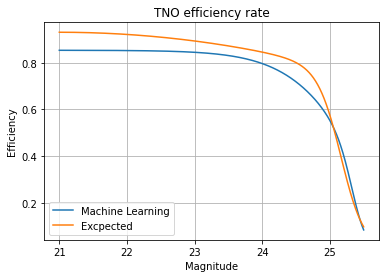

In [14]:

predictions = model.predict( new_data )
print(predictions)

def ft(m,a,b,c,d):
    return a/4 * (1-np.tanh((m-b)/c)) * (1-np.tanh((m-b)/d))

def fs(m,a,b,c,d):
    return (a-b*(m-21)**2) / (1+np.exp((m-c)/d))

m = np.linspace(21,25.5,1000)
plt.plot(m,ft(m,*predictions[0]), label="Machine Learning")
plt.plot(m,fs(m,0.930487275,9.34686325E-03,25.1766472,0.171281680), label="Excpected")
plt.grid()
plt.legend()
plt.title("TNO efficiency rate")
plt.xlabel("Magnitude")
plt.ylabel("Efficiency")
plt.show()